In [45]:
from pathlib import Path
import glob 
import datetime
import matplotlib.pyplot as plt
import numpy
import torch
from sklearn import decomposition

from src.datamodule import ClayDataModule
from src.model_clay import CLAYModule

Total number of chips: 100


/opt/conda/envs/pytorch_custom/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['model.encoder.patch_embedding.rededge.proj.weight', 'model.encoder.patch_embedding.rededge.proj.bias', 'model.encoder.patch_embedding.rededge.norm.weight', 'model.encoder.patch_embedding.rededge.norm.bias', 'model.decoder.embed_to_pixels.rededge.weight', 'model.decoder.embed_to_pixels.rededge.bias']
/opt/conda/envs/pytorch_custom/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


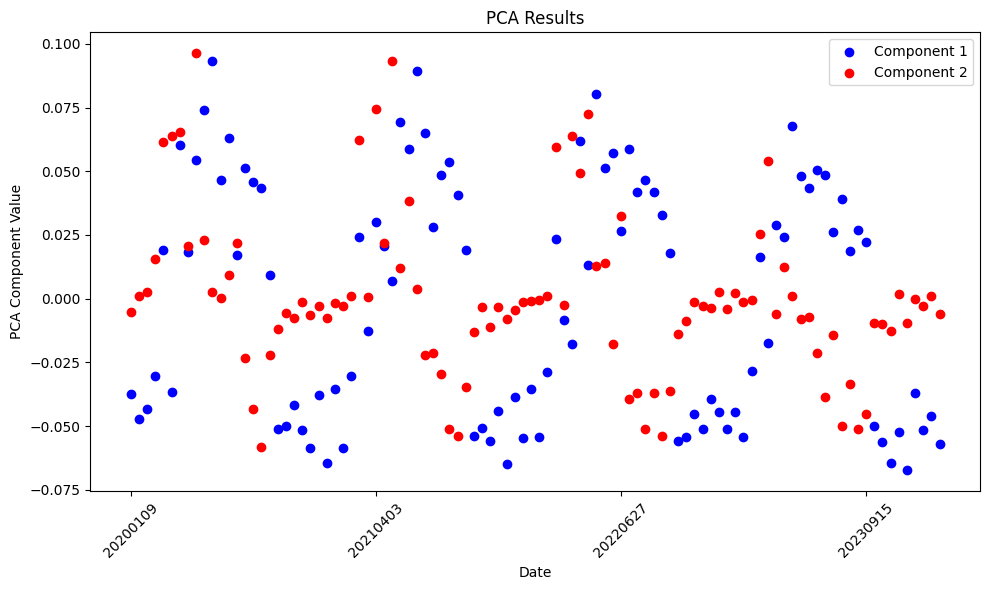

In [54]:
# ###########################################################
# Now switch gears and load the tiles to create embeddings
# and analyze them. Most of the partial input code is copied
# from the partial inputs notebook here
# https://github.com/Clay-foundation/model/blob/docs/model/docs/clay-v0-partial-inputs.ipynb
# ###########################################################

DATA_DIR = "data/minicubes_pakistan" #minicubes_guria" #minicubes_nepal"  # data directory for all chips
CKPT_PATH = "data/checkpoints/Clay_v0.1_epoch-24_val-loss-0.46.ckpt"

# Start date and end date
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 1, 30)

# List to store date ranges
dates = []

# Loop through the dates and create date ranges
for f in glob.glob(f"{DATA_DIR}/*.tif"):
    f = f.split("/")[-1]
    date = f.split("_")[1][:-4]
    dates.append(date)

dates.sort()


rgb_model = CLAYModule.load_from_checkpoint(
    CKPT_PATH,
    mask_ratio=0.0,  # mask out 70% of the input patches
    bands=9,
    band_groups={"rgb": (2, 1, 0), "nir": (3,), "swir": (4,5), "sar": (6,7), "dem": (8,)},
    strict=False,  # ignore the extra parameters in the checkpoint
)
rgb_model.eval()  # set the model to evaluation mode


class ClayDataModuleRGB(ClayDataModule):
    MEAN = [
        1369.03,
        1597.68,
        1741.10,
        2858.43,  # nir
        2303.00, # swir16
        1807.79,  # swir22
        0.026, # vv
        0.118, # vh
        499.46, # dem
    ]
    STD = [
        2026.96,
        2011.88,
        2146.35,
        2016.38,  # nir
        1679.88,  # swir16
        1568.06,  # swir22
        0.118, # vv
        0.873, # vh
        880.35, # dem
        
    ]


data_dir = Path(DATA_DIR)

dm = ClayDataModuleRGB(data_dir=str(data_dir), batch_size=8)
dm.setup(stage="predict")
trn_dl = iter(dm.predict_dataloader())

embeddings = []

for batch in trn_dl:
    with torch.no_grad():
        # Move data from to the device of model
        batch["pixels"] = batch["pixels"].to(rgb_model.device)
        # Pass just the specific band through the model
        batch["timestep"] = batch["timestep"].to(rgb_model.device)
        batch["latlon"] = batch["latlon"].to(rgb_model.device)

        # Pass pixels, latlon, timestep through the encoder to create encoded patches
        (
            unmasked_patches,
            unmasked_indices,
            masked_indices,
            masked_matrix,
        ) = rgb_model.model.encoder(batch)

        embeddings.append(unmasked_patches.detach().cpu().numpy())

embeddings = numpy.vstack(embeddings)

embeddings_mean = embeddings[:, :-2, :].mean(axis=1)

pca = decomposition.PCA(2)

# pca_result = pca.fit_transform(rearrange(embeddings, "o s w -> o (s w)"))
pca_result = pca.fit_transform(embeddings_mean)

numeric_dates = numpy.arange(len(dates))

# Plot the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(numeric_dates, pca_result[:, 0], color="blue", label="Component 1")
plt.scatter(numeric_dates, pca_result[:, 1], color="red", label="Component 2")
plt.xlabel('Date')
plt.ylabel('PCA Component Value')
plt.title('PCA Results')
plt.xticks(ticks=numeric_dates[::30], labels=dates[::30], rotation=45)  # Show every 30th date
plt.legend()
plt.tight_layout()
plt.show()


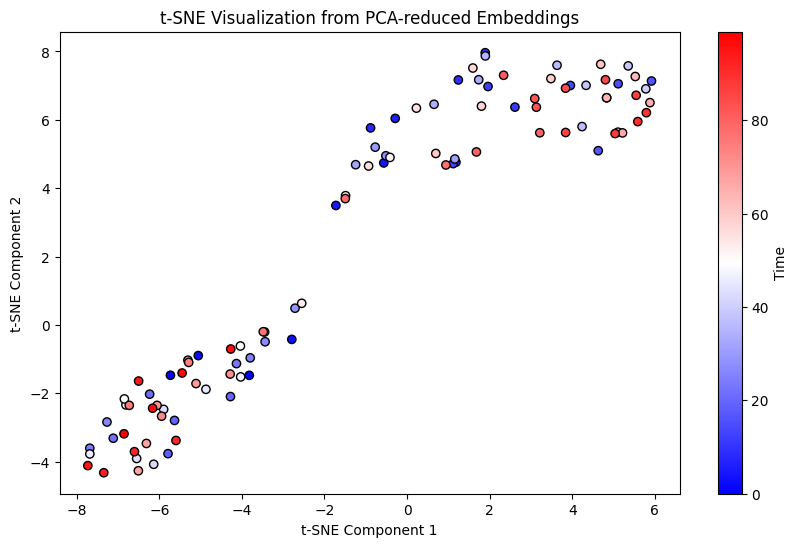

In [55]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE on the PCA-transformed data
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(pca_result)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=numeric_dates, cmap='bwr', edgecolor='k')
plt.title('t-SNE Visualization from PCA-reduced Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Time')
plt.show()
